In [ ]:
!pip install soiltexture

In [ ]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} h5netcdf

In [142]:
from glob import glob
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import soiltexture
import tsfresh
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import xarray as xr
import datetime as dt

## Load Files from disk

In [143]:
filepath_ts = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/download_ts/grassland_DE/'
files = glob(filepath_ts + '*')

In [144]:
# Load all files into one Dataframe
gdf = pd.concat([gpd.read_file(x, ignore_index=True) for x in files])

# Set datetime type
gdf['date'] = gdf['date'].astype('datetime64[ns]')
gdf['date_y'] = gdf['date_y'].astype('datetime64[ns]')

# Add day of year column
gdf['day_of_year'] = gdf['date'].dt.day_of_year
print(len(gdf))

110247


## Combine with Lucas topsoil properties

In [145]:
# Load LUCAS TOPSOIL DATABASE
df_lts = pd.read_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/soil_classification/LTS_grassland_DE.csv').drop(['Unnamed: 0', 'geometry'], axis=1)
gdf_lts = gpd.GeoDataFrame(df_lts, geometry=gpd.points_from_xy(df_lts.GPS_LONG, df_lts.GPS_LAT))

# Join LTS data to S1, S2, Era5 Data
gdf = pd.merge(gdf, gdf_lts, on='POINT_ID', how='left', suffixes=('', '_y')).rename({'geometry_y' : 'geometry'})
print(len(gdf))

110247


In [146]:
# Mask rows without particel size distribution
gdf = gdf[(gdf.sand > 0) & (gdf.silt > 0) & (gdf.clay > 0)]
print(len(gdf))

107401


## Classify soil textures by sand, silt , clay content

In [147]:
# Create USDA classification
USDA_class = list()
FAO_class = list()
INTERNATIONAL_class = list()
ISSS_class = list()
for index, row in gdf.iterrows():
    USDA_class.append(soiltexture.getTexture(row.sand, row.clay, classification='USDA'))
    FAO_class.append(soiltexture.getTexture(row.sand, row.clay, classification='FAO'))
    INTERNATIONAL_class.append(soiltexture.getTexture(row.sand, row.clay, classification='INTERNATIONAL'))
    ISSS_class.append(soiltexture.getTexture(row.sand, row.clay, classification='ISSS'))
                      
gdf['USDA'] = USDA_class
gdf['FAO'] = FAO_class
gdf['INTERNATIONAL'] = INTERNATIONAL_class
gdf['ISSS'] = ISSS_class
print(len(gdf))

107401


In [148]:
gdf['USDA'].value_counts(),gdf['FAO'].value_counts(),gdf['INTERNATIONAL'].value_counts(),gdf['ISSS'].value_counts(),

(sandy loam         21760
 loam               19626
 silt loam          17964
 loamy sand         14447
 silty clay loam    11115
 clay loam           8560
 sand                4375
 clay                4069
 silty clay          4066
 sandy clay loam     1419
 Name: USDA, dtype: int64,
 medium    69914
 coarse    25507
 fine      11980
 Name: FAO, dtype: int64,
 silty loam         45806
 silty clay loam    23859
 loamy sand         21694
 silty clay          6916
 loam                4791
 sand                3116
 clay                1219
 Name: INTERNATIONAL, dtype: int64,
 silty clay         17438
 clay loam          16659
 silty clay loam    16099
 sandy loam         14338
 light clay         11848
 loam               10152
 loamy sand          8071
 heavy clay          4100
 silt loam           3643
 sand                1864
 sandy clay loam     1236
 Name: ISSS, dtype: int64)

### Soil textures categorical to numerical classes

In [149]:
FAO_to_numerical = {'FAO':     {'medium': int(0), 'coarse': int(1), 'fine' : int(2)}}
gdf['FAO_nr'] = gdf.replace(FAO_to_numerical)['FAO']
gdf['FAO_nr'] = gdf['FAO_nr']

USDA_to_numerical = {'USDA':     {'sandy loam': int(0), 'loam': int(1), 'silt loam' : int(2),'loamy sand': int(3), 'silty clay loam': int(4), 'clay loam' : int(5),'sand': int(6), 'clay': int(7), 'silty clay' : int(8), 'sandy clay loam' : int(8)}}
gdf['USDA_nr'] = gdf.replace(USDA_to_numerical)['USDA']
gdf['USDA_nr'] = gdf['USDA_nr']
print(len(gdf))

107401


## Visualize locations 

https://pbpython.com/categorical-encoding.html

In [150]:
longitude = list(dict.fromkeys(gdf.geometry.x))
latitude = list(dict.fromkeys(gdf.geometry.y))
point_id = list(dict.fromkeys(gdf.POINT_ID))

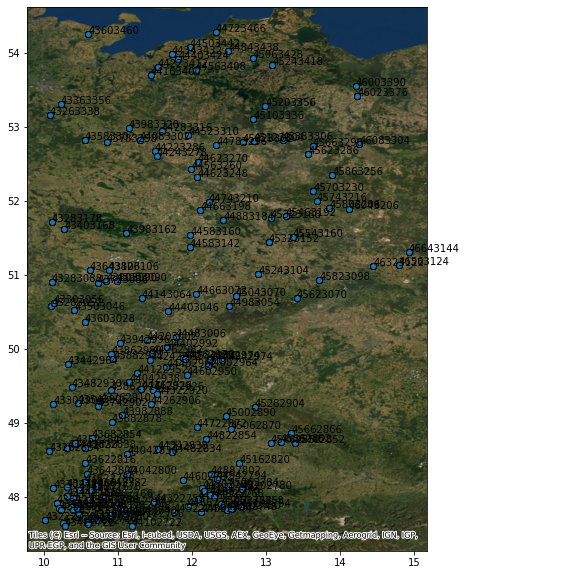

In [151]:
# Visualize Points
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', )
cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldImagery, crs=gdf.crs, zoom = 'auto')
for x, y, label in zip(longitude, latitude, [str(x) for x in point_id]):
    ax.annotate(label, xy=(x, y))

## Add Rainfall data

    Für Morning Aquisition also 5 uhr ist 0 day der tag vor dem tag und für abend aquisition also 17 uhr ist 0 day der gleiche tag
    0 day
    1 day
    2 day

In [152]:
RADOLAN = xr.open_dataset('D:/jupy_data/precipitation_1km.nc')
pp_24h, pp_48h, pp_72h = list(), list(), list()
midday = dt.time(12,0)

for index, row in gdf.iterrows():
    pp_loc = RADOLAN.sel(latitude=row.geometry.y, longitude=row.geometry.x, method='nearest').sel(time=slice(row.date.date() - pd.Timedelta('3d'), row.date.date())).precipitation_1km
    if row.date.time() > midday:
        try:
            pp_24h.append(pp_loc.isel(time=3).values)
            pp_48h.append(pp_loc.isel(time=slice(2,4)).sum().values)  
            pp_72h.append(pp_loc.isel(time=slice(1,4)).sum().values)  
        except:
            pp_24h.append(np.nan)
            pp_48h.append(np.nan)
            pp_72h.append(np.nan)
    else:
        try:
            pp_24h.append(pp_loc.isel(time=2).values)
            pp_48h.append(pp_loc.isel(time=slice(1,3)).sum().values)  
            pp_72h.append(pp_loc.isel(time=slice(0,3)).sum().values)  
        except:
            pp_24h.append(np.nan)
            pp_48h.append(np.nan)
            pp_72h.append(np.nan)
gdf['pp_24h'] = pp_24h
gdf['pp_48h'] = pp_48h
gdf['pp_72h'] = pp_72h

## Subset data

In [154]:
# Subset Data
gdf['longitude'] = gdf['geometry'].x
gdf['latitude'] = gdf['geometry'].y
gdf_subset_1 = gdf.loc[:,['POINT_ID','date', 'VV','VH','angle', 'orbit', 'platform', 'NDVI','day_of_year', 'FAO_nr', 
                          'USDA_nr','minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']]

gdf_subset_1['minimum_2m_air_temperature'] = gdf_subset_1['minimum_2m_air_temperature'] -273.15
#Drop frozen grounds
gdf_subset_1 = gdf_subset_1[gdf_subset_1['minimum_2m_air_temperature'] > 1]
# Drop rows (axis=0) with na values
gdf_subset_1.dropna(how='any', axis=0, inplace=True)

# One Hot Encoding
gdf_subset_1['FAO_nr'] = gdf_subset_1['FAO_nr'].astype('int64')
gdf_subset_1['FAO'] = gdf_subset_1['FAO_nr']

gdf_subset_1['USDA_nr'] = gdf_subset_1['USDA_nr'].astype('int64')
gdf_subset_1['USDA'] = gdf_subset_1['USDA_nr']

df_sub = pd.DataFrame(pd.get_dummies(gdf_subset_1, columns=['platform', 'orbit', 'FAO_nr', 'USDA_nr']))
print(len(df_sub))

81192


## Outlizers
Maybe not necesarry with 30m mean values from s1 s2 era5?

In [ ]:
# Drop lower and upper 1% of data to eliminate outliers
for column in ['VV', 'VH', 'NDVI']:
    df_sub = df_sub[df_sub[column].gt(gdf[column].quantile(0.01)) & df_sub[column].lt(df_sub[column].quantile(0.99))]

## Normalization

### for all values together

In [155]:
scaler = MinMaxScaler() 
df_sub.loc[:,['VV', 'VH', 'angle', 'NDVI', 'day_of_year', 'minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']
          ] = scaler.fit_transform(df_sub.loc[:,['VV', 'VH', 'angle', 'NDVI', 'day_of_year', 
                                                 'minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']]) 

df_sub.dropna(how='any', inplace=True)
df_sub.reset_index(drop=True, inplace=True)

In [ ]:
df_sub.info()

### for every location indepentently

In [ ]:
scaler = MinMaxScaler() 
df_sub.loc[:,['VV', 'VH', 'angle', 'NDVI', 'day_of_year', 'minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']] = df_sub.groupby('POINT_ID')[['VV', 'VH', 'angle', 'NDVI', 'day_of_year', 'minimum_2m_air_temperature','pp_24h', 'pp_48h', 'pp_72h']].agg(scaler.fit_transform()) 

https://www.tensorflow.org/tutorials/structured_data/time_series normalize only with training data

In [ ]:
# Normalize Data
df_sub['VV'] = df_sub.groupby('POINT_ID')['VV'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['VH'] = df_sub.groupby('POINT_ID')['VH'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['angle'] = df_sub.groupby('POINT_ID')['angle'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['NDVI'] = df_sub.groupby('POINT_ID')['NDVI'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['day_of_year'] = df_sub.groupby('POINT_ID')['day_of_year'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['dewpoint_2m_temperature'] = df_sub.groupby('POINT_ID')['dewpoint_2m_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['maximum_2m_air_temperature'] = df_sub.groupby('POINT_ID')['maximum_2m_air_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['mean_2m_air_temperature'] = df_sub.groupby('POINT_ID')['mean_2m_air_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['minimum_2m_air_temperature'] = df_sub.groupby('POINT_ID')['minimum_2m_air_temperature'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['surface_pressure'] = df_sub.groupby('POINT_ID')['surface_pressure'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['total_precipitation'] = df_sub['total_precipitation'].apply(lambda x: (x - df_sub['total_precipitation'].mean()) / df_sub['total_precipitation'].std())
df_sub['u_component_of_wind_10m'] = df_sub.groupby('POINT_ID')['u_component_of_wind_10m'].transform(lambda x: (x - x.mean()) / x.std())
df_sub['v_component_of_wind_10m'] = df_sub.groupby('POINT_ID')['v_component_of_wind_10m'].transform(lambda x: (x - x.mean()) / x.std())

def normalization(x):
    mean = x.mean()
# Transform to percentage particel distribution
#df_sub['sand'] = df_sub['sand'] / 100
#df_sub['clay'] = df_sub['clay'] / 100
#df_sub['silt'] = df_sub['silt'] / 100
df_sub.reset_index(drop=True, inplace=True)

# Plot normalized Distribution 

In [ ]:
df_std = (df_sub.iloc[:,2:11] - df_sub.iloc[:,2:11].mean()) / df_sub.iloc[:,2:11].std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_sub.iloc[:,2:11].keys(), rotation=90)

In [86]:
df_sub.columns

Index(['POINT_ID', 'date', 'VV', 'VH', 'angle', 'NDVI', 'day_of_year',
       'minimum_2m_air_temperature', 'pp_24h', 'pp_48h', 'pp_72h', 'FAO',
       'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING',
       'FAO_nr_0', 'FAO_nr_1', 'FAO_nr_2'],
      dtype='object')

## Feature Extracting

### for all features

In [157]:
from tsfresh import extract_relevant_features
df_features = df_sub[['POINT_ID', 'date', 'VV', 'VH', 'angle', 'NDVI', 'day_of_year',
       'minimum_2m_air_temperature', 'pp_24h', 'pp_48h', 'pp_72h',
       'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING']]

y_features = df_sub[['POINT_ID','USDA']].drop_duplicates()
y_features = y_features.set_index('POINT_ID')['USDA']

relevant_features = extract_relevant_features(df_features, y_features, column_id='POINT_ID', column_sort='date')
relevant_features['USDA'] = y_features

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [05:07<00:00, 30.73s/it]


In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(relevant_features, y_features, test_size=.3)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test),labels = list(USDA_to_numerical['USDA'].values()), target_names = list(USDA_to_numerical['USDA'].keys()) ))

                 precision    recall  f1-score   support

     sandy loam       1.00      1.00      1.00        12
           loam       1.00      1.00      1.00        10
      silt loam       1.00      1.00      1.00        10
     loamy sand       1.00      1.00      1.00         7
silty clay loam       1.00      1.00      1.00         4
      clay loam       1.00      1.00      1.00         3
           sand       1.00      1.00      1.00         3
           clay       1.00      1.00      1.00         3
     silty clay       1.00      1.00      1.00         1
sandy clay loam       1.00      1.00      1.00         1

       accuracy                           1.00        54
      macro avg       1.00      1.00      1.00        54
   weighted avg       1.00      1.00      1.00        54



In [167]:
list(USDA_to_numerical['USDA'].items())

[('sandy loam', 0),
 ('loam', 1),
 ('silt loam', 2),
 ('loamy sand', 3),
 ('silty clay loam', 4),
 ('clay loam', 5),
 ('sand', 6),
 ('clay', 7),
 ('silty clay', 8),
 ('sandy clay loam', 8)]

In [127]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=6000, class_weight='balanced')

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.5263157894736842

In [107]:
from tsfresh import extract_relevant_features
df_features_small = df_sub[(df_sub['platform_A'] == 1 ) & (df_sub['orbit_ASCENDING'] == 1 )]
df_features_small = df_features_small[['POINT_ID', 'date', 'VV', 'VH', 'angle', 'NDVI', 'day_of_year',
       'minimum_2m_air_temperature', 'pp_24h', 'pp_48h', 'pp_72h']]

y_features_small = df_sub[['POINT_ID','FAO']].drop_duplicates()
y_features_small = y_features_small.set_index('POINT_ID')['FAO']

relevant_features_small = extract_relevant_features(df_features_small, y_features_small, column_id='POINT_ID', column_sort='date')
relevant_features_small['FAO'] = y_features_small

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.66s/it]


In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(relevant_features_small, y_features_small, test_size=.4)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.80      0.94      0.86        17
           2       0.67      0.33      0.44         6

    accuracy                           0.90        50
   macro avg       0.82      0.76      0.77        50
weighted avg       0.89      0.90      0.89        50



## Descion Tree 
https://keras.io/examples/structured_data/deep_neural_decision_forests/

In [156]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING', 'minimum_2m_air_temperature',
            'pp_24h', 'pp_48h', 'pp_72h']].values
#y = df_sub[['FAO_nr_0', 'FAO_nr_1', 'FAO_nr_2']].values #One Hot encoded
#y = df_sub['FAO'].values
y = df_sub['USDA'].values

# transform the dataset BALANCE dataset
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

## Split Training Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      5908
           1       0.81      0.81      0.81      5087
           2       0.79      0.79      0.79      4709
           3       0.85      0.85      0.85      3991
           4       0.80      0.79      0.79      2869
           5       0.77      0.79      0.78      2226
           6       0.85      0.85      0.85      1169
           7       0.78      0.81      0.80      1011
           8       0.83      0.82      0.82      1443

    accuracy                           0.82     28413
   macro avg       0.81      0.82      0.82     28413
weighted avg       0.82      0.82      0.82     28413



# Classification
## Multi Time Series with irregular time intervals

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

one epoch = one forward pass and one backward pass of all the training examples
batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

## Multi-Class Classification with imbalanced Dataset

In [ ]:
To-Do Balance Dataset
!!Check!! Use only not winter values
!!Check!! Find 24h rain 48 rain and 72h rainamount before acquisition
use Tensorboard stuff https://www.tensorflow.org/tensorboard


In [ ]:
# Show imbalanced
df_sub['FAO'].value_counts().values

In [136]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
X = df_sub[['VV', 'VH', 'NDVI','angle', 'day_of_year', 'platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
            'pp_24h', 'pp_48h', 'pp_72h']].values
y = df_sub[['FAO_nr_0', 'FAO_nr_1', 'FAO_nr_2']].values #One Hot encoded
#y = df_sub['FAO'].values

## Split Training Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Use Balancing 

    SMOTE balancing decrease results

In [ ]:
# transform the dataset BALANCE dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

### or Weights

In [ ]:
totals = df_sub['FAO'].value_counts().values
totalMean = totals.mean()
weights = {i: totalMean / count for i, count in enumerate(totals)}

## Model Building

    ouput dense layer always softmax for multiclass (mutual exclusiv)
    loss also categorical_crossentropy for multiclass
    optimizer = rmsprop

## with Keras, Tensorflow

### Sequential API

    V1

In [134]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #https://scikit-learn.org/stable/modules/model_evaluation.html
    return model

# Compile model
model = baseline_model()

    if from feature extraction method use this to ensure one hot encoded values

In [133]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [120]:
# Callbacks
# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='accuracy', patience=5)

model.fit(x=X_train, y=y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), callbacks=[stop_improving])

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Train on 75 samples, validate on 50 samples
Epoch 1/100
75/75 [==============================] - 0s 6ms/step - loss: 1457.8205 - accuracy: 0.3733 - val_loss: 2109.8418 - val_accuracy: 0.0400
Epoch 2/100
75/75 [==============================] - 0s 833us/step - loss: 1415.8166 - accuracy: 0.4133 - val_loss: 1355.9148 - val_accuracy: 0.6000
Epoch 3/100
75/75 [==============================] - 0s 712us/step - loss: 701.1096 - accuracy: 0.6267 - val_loss: 683.7748 - val_accuracy: 0.3600
Epoch 4/100
75/75 [==============================] - 0s 625us/step - loss: 797.6568 - accuracy: 0.2800 - val_loss: 260.6208 - val_accuracy: 0.1400
Epoch 5/100
75/75 [==============================] - 0s 712us/step - loss: 266.1497 - accuracy: 0.4533 - val_loss: 589.8442 - val_accuracy: 0.6000
Epoch 6/100
75/75 [==============================] - 0s 625us/step - loss: 556.7292 - accuracy: 0.6400 - val_loss: 186.9721 - val_accuracy: 0.7800
Epoch 7/100
75/75 [==============================] - 0s 712us/step - los

    V2

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=X.shape[0], verbose=1) #verbose=0 debugging=off
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    For feature extraction

In [135]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=X_train.shape[0], verbose=1) #verbose=0 debugging=off
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/10
100/100 [==============================] - 1s 7ms/step - loss: 698.7097 - accuracy: 0.1800
Epoch 2/10
100/100 [==============================] - 0s 200us/step - loss: 1107.1255 - accuracy: 0.6400
Epoch 3/10
100/100 [==============================] - 0s 179us/step - loss: 586.8103 - accuracy: 0.6400
Epoch 4/10
100/100 [==============================] - 0s 265us/step - loss: 2298.5310 - accuracy: 0.2700
Epoch 5/10
100/100 [==============================] - 0s 202us/step - loss: 2022.6793 - accuracy: 0.2700
Epoch 6/10
100/100 [==============================] - 0s 180us/step - loss: 839.7894 - accuracy: 0.4700
Epoch 7/10
100/100 [==============================] - 0s 207us/step - loss: 1337.2662 - accuracy: 0.6400
Epoch 8/10
100/100 [==============================] - 0s 250us/step - loss: 1767.4828 - accuracy: 0.6400
Epoch 9/10
100/100 [==============================] - 0s 174us/step - loss: 1924.9165 - accuracy: 0.6400
Epoch 10/10
12/12 [==============================] - 0s 16ms

Epoch 6/10
101/101 [==============================] - 0s 99us/step - loss: 1483.3855 - accuracy: 0.6436
Epoch 7/10
101/101 [==============================] - 0s 102us/step - loss: 1648.4232 - accuracy: 0.6436
Epoch 8/10
101/101 [==============================] - 0s 161us/step - loss: 1598.7274 - accuracy: 0.6436
Epoch 9/10
101/101 [==============================] - 0s 97us/step - loss: 1381.2894 - accuracy: 0.6436
Epoch 10/10
11/11 [==============================] - 0s 19ms/step
Epoch 1/10
101/101 [==============================] - 0s 3ms/step - loss: 759.7931 - accuracy: 0.2574
Epoch 2/10
101/101 [==============================] - 0s 200us/step - loss: 1675.8612 - accuracy: 0.6436
Epoch 3/10
101/101 [==============================] - 0s 197us/step - loss: 1903.4163 - accuracy: 0.6436
Epoch 4/10
101/101 [==============================] - 0s 197us/step - loss: 1629.0959 - accuracy: 0.6436
Epoch 5/10
101/101 [==============================] - 0s 199us/step - loss: 1520.4845 - accuracy: 0

## sklearn logistic regression
    V3 
    less features dont make better results

In [78]:
#dataset = df_sub[df_sub['date'].dt.year.isin([2018])].values
#X = df_sub[['VV', 'VH', 'NDVI', 'day_of_year', 'platform_A', 'platform_B', 
#            'orbit_ASCENDING', 'orbit_DESCENDING','minimum_2m_air_temperature',
#            'pp_24h', 'pp_48h', 'pp_72h']].values
X = df_sub[['VV', 'NDVI','platform_A', 'platform_B', 
            'orbit_ASCENDING', 'orbit_DESCENDING']].values
#y = df_sub[['FAO_nr_0', 'FAO_nr_1', 'FAO_nr_2']].values #One Hot encoded
y = df_sub['FAO'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [75]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=350, class_weight='balanced')

model.fit(X_train, y_train)

model.score(X_test, y_test)

In [ ]:
features = ['VV', 'VH', 'NDVI', 'platform_A', 'platform_B', 'orbit_ASCENDING', 'orbit_DESCENDING', 'day_of_year', 'FAO_nr']
y_label = 'FAO_nr'

In [ ]:
# Dataframe Statistics 
train_stats = df_sub[features].describe()
train_stats.pop(y_label)
train_stats = train_stats.transpose()

In [ ]:
# Split into Train and Test 
df = df_sub[features].reset_index(drop=True)
train_df = df.sample(frac = 0.8, random_state=0)
test_df = df.drop(train_df.index)

train_labels = train_df.pop(y_label)
test_labels = test_df.pop(y_label)

In [ ]:
# The Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.nn import relu
#from tensorflow.nn import linear
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

#Architecture 
def build_model(optimizer):
    model = Sequential([
        layers.Dense(128, activation=relu, input_shape=[len(train_df.keys())]), # densly (fully connected) hidden layer
        layers.Dense(64, activation=relu), # denly hidden layer
        layers.Dense(1, activation='linear') #output layer
    ])

    model.compile(
        loss = 'mse', # https://keras.io/api/losses/
        optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
        metrics = ['mae', 'mse', 'accuracy']) 

    return model

model = build_model(optimizer = Adam(.001))

#Inspect Model
model_summary = model.summary()


## Train the model
# Callbacks
"""
class Calls(Callback):
    #Print dot every epoch while training
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
"""
# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(
    x = train_df,
    y = train_labels,
    epochs = EPOCHS,
    validation_split = 0.2, 
    verbose = 0,
    callbacks = [stop_improving]) # Calls()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


def plot_history(hitsory):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [m^3/m^3]')
    plt.plot(hist['epoch'], hist['mae'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [m^3/m^3^2]')
    plt.plot(hist['epoch'], hist['mse'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

plot_history(history)
print(f'metrics_names : {model.metrics_names}')
loss, mae, mse, accuracy = model.evaluate(test_df, test_labels, verbose = 0)
print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))
print("Testing set Mean squared Error: {:5.2f} m^3/m^3".format(mse))
print("Testing set Accuracy: {:5.2f} m^3/m^3".format(accuracy))

## Make Predictions
test_predictions = model.predict(test_df).flatten()

plt.figure()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values m^3/m^3')
plt.ylabel('Predictions m^3/m^3')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
plot_predict_scatter = plt.plot([-100,100], [-100,100])
print(plot_predict_scatter)

plt.figure()
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error m^3/m^3')
plot_error_hist = plt.ylabel('Count')
print(plot_error_hist)


In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


In [ ]:
plotterAccLoss = AccLossPlotter(graphs=['acc', 'loss'], save_graph=True)
plotterConfusion = ConfusionMatrixPlotter(X_val=X_test, classes=['0', '1', '2'], Y_val=y_test)
classificationReport = ClassificationReport(X_val=X_test, classes=['0', '1', '2'], Y_val=y_test)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='categorical_crossentropy', factor=0.2, patience=3, min_lr=0.00001)


import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

class AccLossPlotter(tf.keras.callbacks.Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class

    Adapted from: https://github.com/chasingbob/keras-visuals/blob/master/visual_callbacks.py

    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """
    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph

    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Val')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Val')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(tf.keras.callbacks.Callback):
    """Plot the confusion matrix on a graph and update after each epoch

    Adapted from: https://github.com/chasingbob/keras-visuals/blob/master/visual_callbacks.py

    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        plt.figure()
        plt.title(self.title)

    def on_train_begin(self, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = np.argmax(self.Y_val, axis=1)
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)
        plt.colorbar()                                                                       
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        plt.show()
        plt.pause(0.001)


class ClassificationReport(tf.keras.callbacks.Callback):
    """Print the scikit-learn classification_report after each epoch

    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
    """
    def __init__(self, X_val, Y_val, classes, normalize=False):
        self.X_val = X_val
        self.Y_val = Y_val
        self.classes = classes

    def on_train_begin(self, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):   
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = np.argmax(self.Y_val, axis=1)
        print(classification_report(max_y, max_pred, target_names=self.classes))

# stop the training when there is no improvement in the loss for three consecutive epochs.
stop_improving = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
x_train

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train

# CNN - MLP - train model with regression problematic 

In [ ]:
def mlp_lr_sm(paths, features, y_label, networks, stations, climates,use_date_as_var, ndvi_low, ndvi_high, allow_frozen_state,loss_function, optimizer, metrics, save_to):
    """
    Arguments:
    """
    
    
    # Import modules
    from glob import glob
    import datetime as dt
    import geopandas as gpd
    import pandas as pd
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler
    
    ## Initialize data
    # Files with data
    paths = glob(paths)
    paths.sort()

    # Create Station id linked with filepath
    ids = [x.split('\\')[-1].split('_')[0] for x in paths]
    files = dict(zip(ids,paths))

    # Load all files into one Dataframe
    gdf = gpd.tools.util.pd.concat(map(gpd.read_file, paths), ignore_index=True)
    print(f'Rows before preprocessing {len(gdf)}')
    
    
    ## Preprocessing
    # Set type of date column to datetime object
    gdf.date = gdf.date.astype('datetime64[ns]')
    
    #Drop rows without Sentinel 2 data
    gdf.dropna(how='any',subset=['NDVI'], inplace=True)
    
    # Convert int to timedelta in days 
    s2_timedelta = [dt.timedelta(days=x) for x in gdf.s2_distance]  
    gdf.s2_distance = s2_timedelta
    
    #Remove uneseccary columns
    gdf.drop(labels = ['CloudMask'], axis = 1, inplace = True)

    # Clean Nan Values within subset columns (major variables to inspect)
    gdf.dropna(how='any', subset=['soil_moisture', 'VV'], inplace=True)

    # Drop lower and upper 1% of data to eliminate outliers
    gdf = gdf[gdf.soil_moisture.gt(gdf.soil_moisture.quantile(0.01)) & gdf.soil_moisture.lt(gdf.soil_moisture.quantile(0.99))]
    gdf = gdf[gdf.VV.gt(gdf.VV.quantile(0.01)) & gdf.VV.lt(gdf.VV.quantile(0.99))]
    gdf = gdf[gdf.NDVI.gt(gdf.NDVI.quantile(0.01)) & gdf.NDVI.lt(gdf.NDVI.quantile(0.99))]

    # Remove rows where ndvi is older than 30days
    gdf = gdf[gdf.s2_distance.gt(dt.timedelta(days=-7)) & gdf.s2_distance.lt(dt.timedelta(days=7))]
    
    # Remove NDVI values outside range because to high ndvi means to dense vegetation and vv is disturbed too much 
    if None not in [ndvi_low, ndvi_high]:
        gdf = gdf[gdf.NDVI.between(ndvi_low,ndvi_high)]
    
    # Remove rows where Temperature is below Zero 273,15 K because VV is in frozen soils not trustworth
    if allow_frozen_state == 'no':
        gdf = gdf[gdf.minimum_2m_air_temperature.gt(273,15)]

    # Choose only specififed Network
    if networks is not None:
        gdf = gdf[gdf['network'].isin(networks)]
    
    # Choose only specified Stations
    if stations is not None:
        gdf = gdf[gdf['station'].isin(stations)]
        
    # Choose only specified climate after Köpping https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification
    if climates is not None:
        gdf = gdf[gdf['climate'].isin(climates)]
    print(f'Rows after preprocessing {len(gdf)}')
    
    # Create a Variable from date convert the timestamps to delta, perform a cumulative sum on the dt feature to get a monotonically increasing value
    # For now use dayofyear 
    if use_date_as_var == True:
        #date_timedelta = [dt.timedelta(x) for x in gdf['date']]
        #date_timedelta_cumsum = np.cumsum(date_timedelta)
        gdf['day_of_year'] = gdf.date.dt.day_of_year
        
        
    ## One Hot Encoding
    gdf = pd.get_dummies(gdf, columns=["platform", "orbit"])
    
    ## Statistics
    #KDE Plot
    #plot_kde = sns.pairplot(gdf[features], diag_kind = 'kde')
    #print(plot_kde)
    
    # Dataframe Statistics 
    train_stats = gdf[features].describe()
    train_stats.pop(y_label)
    train_stats = train_stats.transpose()
    #print(train_stats)
    
    
    ## Split into Train and Test 
    df = pd.DataFrame(gdf[features]).reset_index(drop=True)
    df['sand'] = df['sand'] / 100
    train_df = df.sample(frac = 0.8, random_state=0)
    test_df = df.drop(train_df.index)
    
    train_labels = train_df.pop(y_label)
    test_labels = test_df.pop(y_label)
    scaler = MinMaxScaler()
    print(train_labels)
    features.remove(y_label)
    train_df[features] = scaler.fit_transform(X = train_df[features])
    test_df[features] = scaler.fit_transform(X = test_df[features])
    
    n_train_df = train_df
    n_test_df = test_df
    
    ## Normalize data
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    
    #n_train_df = norm(train_df)
    #n_test_df = norm(test_df)

    ## The Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import layers
    from tensorflow.nn import relu
    #from tensorflow.nn import linear
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras.optimizers import Adam
    from keras.callbacks import Callback
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow as tf
    physical_devices = tf.config.experimental.list_physical_devices('GPU')

    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    
    #Architecture 
    def build_model(optimizer):
        model = Sequential([
            layers.Dense(128, activation=relu, input_shape=[len(n_train_df.keys())]), # densly (fully connected) hidden layer
            layers.Dense(64, activation=relu), # denly hidden layer
            layers.Dense(1, activation='linear') #output layer
        ])

        if optimizer == 'RMSprop':
            optimizer = RMSprop(0.001)
        
        if optimizer == 'Adam':
            optimizer = Adam(.001)
        model.compile(
            loss = loss_function, # https://keras.io/api/losses/
            optimizer = optimizer, #https://keras.io/api/optimizers/#available-optimizers
            metrics = metrics) 

        return model
    
    model = build_model(optimizer)
    
    #Inspect Model
    model_summary = model.summary()
    
    
    ## Train the model
    # Callbacks
    """
    class Calls(Callback):
        #Print dot every epoch while training
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
    """
    # stop the training when there is no improvement in the loss for three consecutive epochs.
    stop_improving = EarlyStopping(monitor='val_loss', patience=10)
    
    EPOCHS = 1000

    history = model.fit(
        x = n_train_df,
        y = train_labels,
        epochs = EPOCHS,
        validation_split = 0.2, 
        verbose = 0,
        callbacks = [stop_improving]) # Calls()
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    import matplotlib.pyplot as plt

    def plot_history(hitsory):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [m^3/m^3]')
        plt.plot(hist['epoch'], hist['mae'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mae'].max() + hist['mae'].max() * 0.5])

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [m^3/m^3^2]')
        plt.plot(hist['epoch'], hist['mse'],
                label = 'Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        plt.legend()
        plt.ylim([0,hist['mse'].max() + hist['mse'].max() * 0.5])

    plot_history(history)
    print(f'metrics_names : {model.metrics_names}')
    loss, mae, mse, accuracy = model.evaluate(n_test_df, test_labels, verbose = 0)
    print("Testing set Mean Abs Error: {:5.2f} m^3/m^3".format(mae))
    print("Testing set Mean squared Error: {:5.2f} m^3/m^3".format(mse))
    print("Testing set Accuracy: {:5.2f} m^3/m^3".format(accuracy))

    ## Make Predictions
    test_predictions = model.predict(n_test_df).flatten()
    
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values m^3/m^3')
    plt.ylabel('Predictions m^3/m^3')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plot_predict_scatter = plt.plot([-100,100], [-100,100])
    print(plot_predict_scatter)
    
    plt.figure()
    error = test_predictions - test_labels
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error m^3/m^3')
    plot_error_hist = plt.ylabel('Count')
    print(plot_error_hist)
    
    #Save Model
    if save_to is not None:
        model.save(save_to)

    return model, gdf

In [ ]:
features_s1 = ['platform', 'orbit', 'VV', 'VH', 'angle', 'img_id'] #latform & orbit are categorical data

features_s2 = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4', 'NIR', 
               'WaterVapor', 'Cirrus', 'SWIR1', 'SWIR2', 'CloudMask', 'NDVI', 'date_y']

features_era5 = ['dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature',
                 'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation', 
                 'u_component_of_wind_10m', 'v_component_of_wind_10m']

features_ismn = ['ismn_id','soil_moisture', 'soil_moisture_flag', 'soil_moisture_orig_flag', 'network', 
                 'station', 'clay', 'sand', 'silt', 'oc', 'climate', 'elevation', 'instrument']

features_4all = ['date','day_of_year', 'geometry']

features_selected = ['day_of_year', 'VV', 'VH', 'angle', 'platform_A', 'platform_B', 'orbit_ASCENDING','orbit_DESCENDING',
                     'NDVI', 'soil_moisture']

networks_all = {'Germany' : ['TERENO'],'Austria' : ['WEGERENET']}

In [ ]:
model, gdf = mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data/*',
    features = features_selected + ['sand'],
    y_label = 'sand',
    networks = None,
    stations = None,
    climates = None,
    use_date_as_var = True,
    ndvi_low = 0,
    ndvi_high = 0.4, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Adam',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy'],
    save_to = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models_soil\soil_ssm'
    )

In [ ]:
model_30m, gdf_30m = mlp_lr_sm(
    paths = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/ground_trouth/CNN_data_30m/*',
    features = features_era5 + features_selected,
    y_label = 'soil_moisture',
    networks = None,
    stations = None,
    climates = None,
    use_date_as_var = True,
    ndvi_low = 0,
    ndvi_high = 0.7, 
    allow_frozen_state = 'no',
    loss_function = 'mae',       # 'mae', 'sparse_categorical_crossentropy'
    optimizer =  'Adam',    # Ftrl adam, Adamax Nadam  'RMSprop',  SGD  RMSprop  Adam  Adadelta  Adagrad         
    metrics = ['mae', 'mse', 'accuracy'],
    save_to = r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm'
    )

In [ ]:
gdf_30m[features_selected]

In [ ]:
# Normalize data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

Merzenhausen = gdf[gdf['station'] == 'Merzenhausen'].copy()
x_Merz_values = Merzenhausen[features_selected + features_era5]
y_Merz_label = x_Merz_values.pop('soil_moisture')

train_stats = x_Merz_values.describe()
train_stats = train_stats.transpose()

x_Merz_norm = norm(x_Merz_values)
y_Merz_predict = model.predict(x_Merz_norm).flatten()
Merzenhausen['sm_predict'] = y_Merz_predict

In [ ]:
import pandas as pd
import hvplot.pandas  # noqa

pd.options.plotting.backend = 'holoviews'

In [ ]:
Merzenhausen.hvplot.scatter(x='date', y=['soil_moisture', 'sm_predict'],groupby='date.year' )

In [ ]:
import numpy as np
(Merzenhausen['soil_moisture'] - Merzenhausen['sm_predict']).sum() / 500

## Print Function names with arguments

In [ ]:
from inspect import getmembers, isfunction, signature
import numpy

def explain(m):
    try:
        return f"{m[0]}{signature(m[1])}"
    except:
        return f"{m[0]}(???)" # some functions don't provide signature

print(*(explain(m) for m in getmembers(irrigation_detection, isfunction)), sep='\n')

In [ ]:
def USDA_classifier(sand,silt,clay):
    soil_class = np.nan
    soil_names = np.nan
    soil_class_nr = np.nan
    soil_names_nr = np.nan
    if sand >= .86 and silt <= .14: #and clay <= .10:
        soil_class = 'Sand'
        soil_names = 'Sandy soils (Coarse texture)'
        soil_class_nr = 0
        soil_names_nr = 0
    elif .7 <= sand <= .86 and silt <= .30: #and clay <= .15:
        soil_class = 'Loamy Sand'
        soil_names = 'Sandy soils (Coarse texture)'
        soil_class_nr = 1
        soil_names_nr = 0
    elif .50 <= sand <= .70 and silt <= .50: #and clay <= .20:
        soil_class = 'Sandy loam'
        soil_names = 'Loamy soils (Moderately coarse texture)'
        soil_class_nr = 2
        soil_names_nr = 1
    elif .23 <= sand <= .52 and .28 <= silt <= .50: #and .07 <= clay <= .27:
        soil_class = 'Loam'
        soil_names = 'Loamy soils (Medium texture)'
        soil_class_nr = 3
        soil_names_nr = 2
    elif .20 <= sand <= .50 and .74 <= silt <= .88: #and clay <= .27:
        soil_class = 'Silty loam'
        soil_names = 'Loamy soils (Medium texture)'
        soil_class_nr = 4
        soil_names_nr = 2
    elif sand <= .20  and .88 <= silt <= .100: #and clay <= .12:
        soil_class = 'Silty'
        soil_names = 'Loamy soils (Medium texture)'
        soil_class_nr = 5
        soil_names_nr = 2
    elif .20 <= sand <= .45 and .15 <= silt <= .52: #and .27 <= clay <= .40:
        soil_class = 'Clay loam'
        soil_names = 'Loamy soils (Moderately fine texture)'
        soil_class_nr = 6
        soil_names_nr = 3
    elif .45 <= sand <= .80 and silt <= .28: #and .20 <= clay <= .35:
        soil_class = 'Sandy clay loam'
        soil_names = 'Loamy soils (Moderately fine texture)'
        soil_class_nr = 7
        soil_names_nr = 3
    elif sand <= .20 and .40 <= silt <= .73: #and .27 <= clay <= .40:
        soil_class = 'Silty clay loam'
        soil_names = 'Loamy soils (Moderately fine texture)'
        soil_class_nr = 8
        soil_names_nr = 3
    elif .45 <= sand <= .60 and silt <= .20: #and .35 <= clay <= .55:
        soil_class = 'Sandy clay'
        soil_names = 'Clayey soils (Fine texture)'
        soil_class_nr = 9
        soil_names_nr = 4
    elif sand <= .20 and .40 <= silt <= .60: #and .40 <= clay <= .60:
        soil_class = 'Silty clay'
        soil_names = 'Clayey soils (Fine texture)'
        soil_class_nr = 10
        soil_names_nr = 4
    elif sand <= .45 and silt <= .40: #and .40 <= clay <= .100:
        soil_class = 'Clay'
        soil_names = 'Clayey soils (Fine texture)'
        soil_class_nr = 11
        soil_names_nr = 4
    return soil_class, soil_names, soil_class_nr, soil_names_nr

In [ ]:
soil_class, soil_names, soil_class_nr, soil_names_nr = list(), list(), list(), list()
for index, row in gdf.iterrows():
    soil_class_i, soil_names_i, soil_class_nr_i, soil_names_nr_i = USDA_classifier(row.sand, row.silt, row.clay)
    soil_class.append(soil_class_i)
    soil_names.append(soil_names_i)
    soil_class_nr.append(soil_class_nr_i)
    soil_names_nr.append(soil_names_nr_i)
gdf['soil_class'] = soil_class
gdf['soil_names'] = soil_names
gdf['soil_class_nr'] = soil_class_nr
gdf['soil_names_nr'] = soil_names_nr